# Titre

In [2]:
import pandas as pd 
import os 
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.metrics import r2_score, mean_squared_error
import importlib
import modeles

importlib.reload(modeles)

from modeles import forecast_quality_oos, ar1_fit_predict, rolling_window_forecast
from modeles import har_fit_predict, garch_fit_predict, msar1_fit_predict
from modeles import expanding_window_forecast, mom_vol_target_weights
from modeles import rebalance_dates_mask, performance_metrics

## traitement des datas

In [3]:
data = pd.read_excel(r"data_v2.xlsx", sheet_name="target", skiprows=1)
data2 = pd.read_excel(r"data_v2.xlsx", sheet_name="features", skiprows=1)

In [4]:
target = data.iloc[:, 1:11].copy()
feat = data2.iloc[:, 1:30].copy()

target = target.set_index(target.columns[0])
feat = feat.set_index(feat.columns[0])

target.index = pd.to_datetime(target.index, format = "%Y%m%d").copy()

## analyse des datas

### Analyse des facteurs action

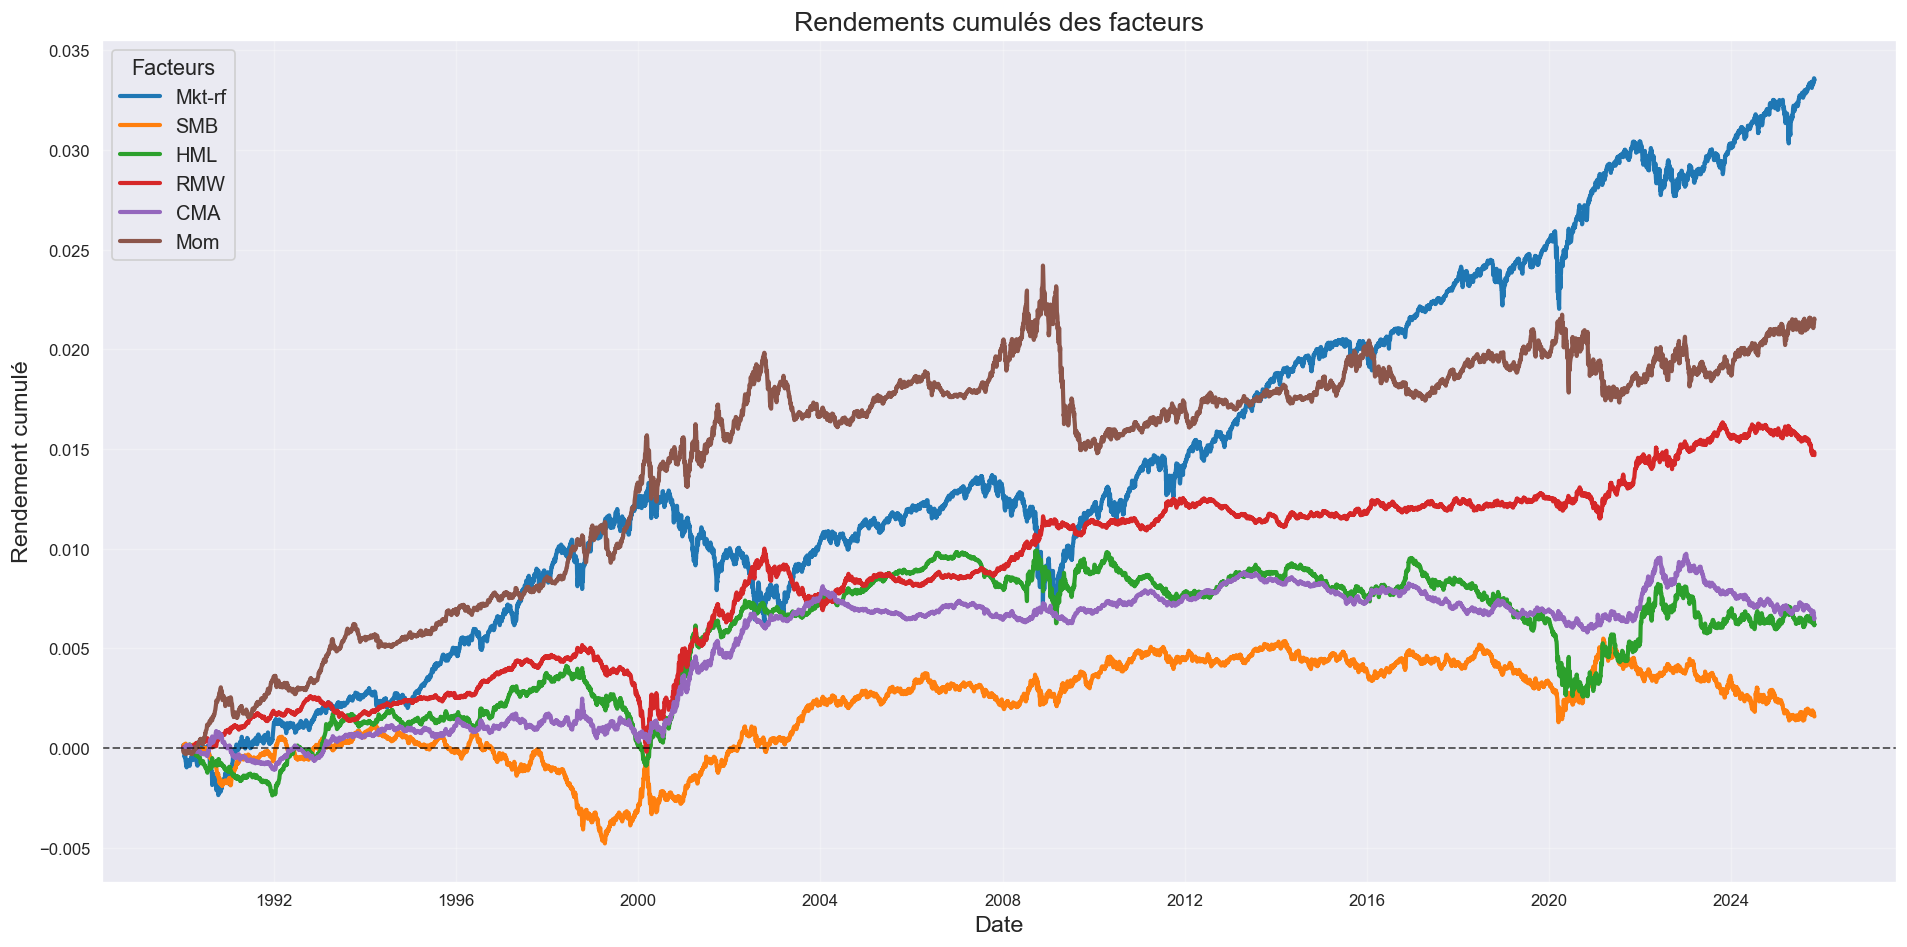

In [5]:

fact = target[["Mkt-rf", "SMB", "HML", "RMW", "CMA", "Mom"]].copy()
fact = fact/100
fact_cumsum = (fact.cumsum()/100).copy()

plt.figure(figsize=(16, 8), dpi=120)

for col in fact.columns:
    plt.plot(
        fact_cumsum.index,
        fact_cumsum[col],
        label=col,
        linewidth=2.5
    )

plt.axhline(
    0,
    linestyle="--",
    linewidth=1.2,
    color="black",
    alpha=0.6
)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rendement cumulé", fontsize=14)
plt.title("Rendements cumulés des facteurs", fontsize=16)

plt.legend(
    title="Facteurs",
    title_fontsize=13,
    fontsize=12,
    loc="upper left",
    frameon=True,
    framealpha=0.9
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Construction des variances réalisées

**Résulé des variables (pandas.Series):**

- ``r`` sont les rendements journaliers du facteur Momentum. Il y a 9026 observation. 

- ``rv_1``, ``rv_5``, ``rv_21`` sont des variances réalisées journalières, hebdomadaires et mensuelles. Elles sont calculées chaque jours, et contiennent respectivement 9026, 9022 et 9006 observations. Nous notons RV les variances réalisées. 

- ``log_rv_1``, ``log_rv_5`` et ``log_rv_21`` sont les RV ``rv_1``, ``rv_5`` et ``rv_21`` en logarithme. La transformation logarithmique est généralement préférée car la variance est très asymétrique, tandis que son logarithme est beaucoup plus proche d’une loi gaussienne et se prête mieux à des modèles linéaires. De plus, le passage en log transforme les chocs de volatilité — empiriquement multiplicatifs — en chocs additifs, ce qui améliore l’interprétation économique et les performances de prévision. Afin d’assurer la stabilité numérique lors du passage au logarithme, nous ajoutons une petite constante espilon à la variance réalisée.

- ``rv_j_1``, ``rv_h_5``, ``rv_m_21`` sont des variances réalisées journalières, hebdomadaires et mensuelles. Elles sont calculées à une fréquence journalière, hebdomadaire et mensuelle de manière à éviter *l'overlap*. En effet, si nous estimions par exemple des RV mensuelles chaque jours alors une grande partie de l'information contenue dans le cible serait présente dans les variables explicatives (*features*). Nous utilions ces RV pour les modèles AR. Elles contiennent respectivement 9026, 1805 et 429 observations. 

- ``log_rv_j_1``, ``log_rv_h_5`` et ``log_rv_m_21`` sont les RV ``rv_j_1``, ``rv_h_5`` et ``rv_m_21`` en logarithme. 

**Résulé des variables (pandas.DataFrame):**

- ``rv_m`` et ``log_rv_m`` contiennent des variances réalisées journalières, hebdomadaires et mensuelles calculées à une fréquence mensuelle. L'utilisation d'un DataFrame permet d'avoir des dates similaires pour les trois types de variance. Ils sont donc utilisées pour les modèles HAR mensuels. 

- ``rv_h`` et ``log_rv_h`` contiennent des variances réalisées journalières, hebdomadaires et mensuelles calculées à une fréquence hebdomadaire. Ils sont donc utilisées pour les modèles HAR hebdomadaires. 

- ``rv_m_as``, ``log_rv_m_as``, ``rv_h_as``, ``log_rv_h_as`` sont les mêmes DataFrames, avec des variables splémentaires, détaillées ci-dessous. Ils sont utilisées pour les HAR-RS, HAR-X, etc. 

In [6]:
# constante pour le passage au logarithme
eps = 1e-12

# Rendements journaliers en décimal
r = target["Mom"].copy() / 100.0

# Variances réalisées, fréquence journalière
rv_1  = r.pow(2).dropna()
rv_5  = r.pow(2).rolling(5).sum().dropna()
rv_21 = r.pow(2).rolling(21).sum().dropna()

# Variances réalisées en logarithme, fréquence journalière
log_rv_21 = np.log(rv_21 + eps)
log_rv_5 = np.log(rv_5 + eps)
log_rv_1 = np.log(rv_1 + eps)

# Variances réalisées fréquence journalière, hebdomadaire et mensuelle
rv_j_1 = rv_1.copy().dropna()
rv_h_5 = rv_5.copy().iloc[::5].dropna()
rv_m_21 = rv_21.copy().iloc[::21].dropna()

# Variances réalisées en logarithme, fréquence journalière, hebdomadaire et mensuelle
log_rv_m_21 = np.log(rv_m_21 + eps)
log_rv_h_5 = np.log(rv_h_5 + eps)
log_rv_j_1 = np.log(rv_j_1 + eps)

**Données pour les HAR :**

Nous regroupons dans un dataframe la série de variance mensuelle à fréquence mensuelle, ainsi que les variances hebdomadaire et journalière. De cette manière nous ne retenons que les dates de la variance mensuelle pour les variances hebdomadaires et journalières afin d'utiliser ce DataFrame pour les HAR mensuels. Il y a 429 observations. Nous créeons également un dataframe basé sur la même méthode à fréquence hebdomadaire, dans lequel il y a 1801 observations. Et enfin nous créeons un dataframe basé sur la même méthode à fréquence journalière avec 9006 observations. 

In [7]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence mensuelle
rv_m = rv_m_21.to_frame("RV 21j").join(rv_5.to_frame("RV 5j"), how = "left")
rv_m = rv_m.join(rv_1.to_frame("RV 1j"), how = "left")

log_rv_m = np.log(rv_m + eps)


In [8]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence hebdomadaire
rv_h = rv_h_5.to_frame("RV 5j").join(rv_21.to_frame("RV 21j"), how = "left")
rv_h = rv_h.join(rv_1.to_frame("RV 1j"), how = "left")
rv_h = rv_h.dropna()

log_rv_h = np.log(rv_h + eps)

In [9]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence hebdomadaire
rv_j = rv_1.to_frame("RV 1j").join(rv_5.to_frame("RV 5j"), how = "left")
rv_j = rv_j.join(rv_21.to_frame("RV 21j"), how = "left")
rv_j = rv_j.dropna()

log_rv_j = np.log(rv_j + eps)

**Données pour les LHAR :**

Nous enrichissons les variables HAR en ajoutant des semi-variances réalisées négatives et une mesure d’asymétrie (« jump »), définie comme la différence entre la variance associée aux rendements positifs et négatifs, afin de capturer les effets asymétriques de la volatilité. 

In [10]:
# Nous initialisons un DataFrame avec les rendements et la variance journalière
r = target["Mom"].copy() / 100.0
r_asym = pd.concat([r, rv_1], axis = 1)
r_asym.columns = ["r", "rv_1"]

# Décomposition asymétrique de la variance en fonction du signe du rendement
r_asym["rv1_pos"] = np.where(r_asym["r"]>0,r_asym["rv_1"], 0)
r_asym["rv1_neg"] = np.where(r_asym["r"]<0,r_asym["rv_1"], 0)

# Construction des variables asymétriques journalières, hebdomadaires et mensuelles
rv_j_1_pos = r_asym["rv1_pos"]
rv_j_1_neg = r_asym["rv1_neg"]
rv_h_5_pos  = r_asym["rv1_pos"].rolling(5).sum().dropna()
rv_h_5_neg  = r_asym["rv1_neg"].rolling(5).sum().dropna()
rv_m_21_neg = r_asym["rv1_neg"].rolling(21).sum().dropna()
rv_m_21_pos = r_asym["rv1_pos"].rolling(21).sum().dropna()
 
# Mesure d'asymétrie (jump) : différence entre variance positive et négative
jump_m = rv_m_21_pos - rv_m_21_neg
jump_h = rv_h_5_pos - rv_h_5_neg
jump_j = rv_j_1_pos - rv_j_1_neg

# On renomme pour les DataFrames
rv_j_1_neg= rv_j_1_neg.rename("RV1_neg")
rv_h_5_neg= rv_h_5_neg.rename("RV5_neg")
rv_m_21_neg= rv_m_21_neg.rename("RV21_neg")
jump_j = jump_j.rename("Jump_j")
jump_h = jump_h.rename("Jump_h")
jump_m = jump_m.rename("Jump_m")

# Ajout des variables aux dataframes HAR journaliers
rv_j_as = rv_j.join(rv_j_1_neg, how = "left")
rv_j_as = rv_j_as.join(rv_h_5_neg, how = "left")
rv_j_as = rv_j_as.join(rv_m_21_neg, how = "left")
rv_j_as = rv_j_as.join(jump_j, how = "left")
rv_j_as = rv_j_as.join(jump_h, how = "left")
rv_j_as = rv_j_as.join(jump_m, how = "left")

# Ajout des variables aux dataframes HAR hebdomadaires
rv_h_as = rv_h.join(rv_j_1_neg, how = "left")
rv_h_as = rv_h_as.join(rv_h_5_neg, how = "left")
rv_h_as = rv_h_as.join(rv_m_21_neg, how = "left")
rv_h_as = rv_h_as.join(jump_j, how = "left")
rv_h_as = rv_h_as.join(jump_h, how = "left")
rv_h_as = rv_h_as.join(jump_m, how = "left")

# Ajout des variables aux dataframes HAR mensuels
rv_m_as = rv_m.join(rv_j_1_neg, how = "left")
rv_m_as = rv_m_as.join(rv_h_5_neg, how = "left")
rv_m_as = rv_m_as.join(rv_m_21_neg, how = "left")
rv_m_as = rv_m_as.join(jump_j, how = "left")
rv_m_as = rv_m_as.join(jump_h, how = "left")
rv_m_as = rv_m_as.join(jump_m, how = "left")

# colonnes à selectionner pour le logarithme (toutes sauf 'jump')
cols_log_j = rv_j_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])
cols_log_h = rv_h_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])
cols_log_m = rv_m_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])

# application du log uniquement sur ces colonnes
log_rv_j_as = rv_j_as.copy()
log_rv_h_as = rv_h_as.copy()
log_rv_m_as = rv_m_as.copy()
log_rv_j_as[cols_log_j] = np.log(rv_j_as[cols_log_j]+ eps)
log_rv_h_as[cols_log_h] = np.log(rv_h_as[cols_log_h]+ eps)
log_rv_m_as[cols_log_m] = np.log(rv_m_as[cols_log_m]+ eps)

print(log_rv_j_as)

                RV 1j     RV 5j    RV 21j    RV1_neg    RV5_neg  RV21_neg  \
Date                                                                        
1990-01-30  -9.952468 -9.633155 -8.058788  -9.952468  -9.640662 -8.320394   
1990-01-31 -12.639937 -9.688376 -8.502748 -27.631021  -9.750423 -8.972426   
1990-02-01 -10.442713 -9.308284 -8.410763 -27.631021  -9.750423 -9.051202   
1990-02-02 -10.637040 -9.129406 -8.356308 -27.631021  -9.863882 -9.155000   
1990-02-05 -13.142566 -9.152260 -8.398033 -13.142566  -9.912125 -9.250225   
...               ...       ...       ...        ...        ...       ...   
2025-10-27 -10.720385 -8.042731 -6.776885 -27.631021  -8.668656 -7.075251   
2025-10-28  -9.656627 -8.438243 -6.725259 -27.631021 -12.754254 -7.075251   
2025-10-29  -7.884964 -7.435558 -6.481390 -27.631021 -27.631021 -7.129787   
2025-10-30 -16.223445 -7.507357 -6.798354 -16.223445 -16.223445 -7.862735   
2025-10-31 -10.557029 -7.624069 -6.776367 -10.557029 -10.553575 -7.800281   

**Données pour le LHAR-X :**

Nous ajoutons la série VIX aux DataFrames pour le LHAR-X. 

In [11]:
feat = feat.copy().ffill()

log_rv_j_as = log_rv_j_as.join(feat["VIXCLS"],  how = "left") 
log_rv_h_as = log_rv_h_as.join(feat["VIXCLS"],  how = "left") 
log_rv_m_as = log_rv_m_as.join(feat["VIXCLS"],  how = "left") 

### Analyse des volatilitées

Nous calculons les volatilitées annualisées du facteur Momentum. 

In [ ]:
# Volatilités annualisées
vol_1_ann  = np.sqrt(252 * rv_1)
vol_5_ann  = np.sqrt(252/5 * rv_5)
vol_21_ann = np.sqrt(252/21 * rv_21)

Nous représentons graphiquement la volatilité hebdomadaire annualisée ainsi que la performance cummulée du facteur Momentum. ²

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), dpi=120, sharex=True)

# --- Graph 1 : cumul du momentum ---
mom_cum = target['Mom'].cumsum()
axes[0].plot(mom_cum.index, mom_cum, label="Momentum cumulé")
axes[0].set_title("Performance cumulée du momentum")
axes[0].set_ylabel("Cumul")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Graph 2 : volatilité hebdomadaire annualisée ---
# (on trace avec l'index de vol_5_ann, pas data.index)
axes[1].plot(vol_5_ann.index, vol_5_ann, label="Volatilité hebdomadaire annualisée")
axes[1].set_title("Volatilité hebdomadaire annualisée")
axes[1].set_ylabel("Volatilité")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Pour éviter l'overlap nous construisons 3 séries : jours, hhebdo et mois 

test de RU

In [ ]:
rv_m_t = rv_m_21.iloc[40:160]
print(len(rv_m_t))

In [ ]:

# ADF avec constante
adf_c = adfuller(rv_m_t, regression="c", autolag="AIC")

# ADF avec constante + trend
adf_ct = adfuller(rv_m_t, regression="ct", autolag="AIC")

print("ADF (constante)")
print("  stat   :", adf_c[0])
print("  p-value:", adf_c[1])
print("  lags   :", adf_c[2])
print("  crit   :", adf_c[4])

print("\nADF (constante + trend)")
print("  stat   :", adf_ct[0])
print("  p-value:", adf_ct[1])
print("  lags   :", adf_ct[2])
print("  crit   :", adf_ct[4])


## Prédiction de variance

### Random walk

In [ ]:
log_rv21_rw_fcst = log_rv_m_21.shift(1)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_m_21,
    y_pred=log_rv21_rw_fcst
)

print(oos_metrics)

log_rv5_rw_fcst = log_rv_h_5.shift(1)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_h_5,
    y_pred=log_rv5_rw_fcst
)

print(oos_metrics)

log_rv1_rw_fcst = log_rv_j_1.shift(1)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_j_1,
    y_pred=log_rv1_rw_fcst
)

print(oos_metrics)



**Prédiction hebdomadaire :**

### Modèles AR

**AR(1) mensuel** :

In [ ]:
log_rv21_ar1_fcst = rolling_window_forecast(
    y=log_rv_m_21,
    fit_predict_fn=ar1_fit_predict,
    window=120,
)

# log_rv21_ar1_fcst = expanding_window_forecast(
#     y=log_rv_m_21,
#     fit_predict_fn=ar1_fit_predict,
#     min_window = 240,
# )

oos_metrics = forecast_quality_oos(
    y_true=log_rv_m_21,
    y_pred=log_rv21_ar1_fcst
)

print(oos_metrics)

**AR(1) hebdomadaire** :

In [ ]:
log_rv5_ar1_fcst = rolling_window_forecast(
    y=log_rv_h_5,
    fit_predict_fn=ar1_fit_predict,
    window=780,
)

log_rv5_ar1_fcst = expanding_window_forecast(
    y=log_rv_h_5,
    fit_predict_fn=ar1_fit_predict,
    min_window=780,
)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_h_5,
    y_pred=log_rv5_ar1_fcst
)

print(oos_metrics)

In [ ]:

log_rv1_ar1_fcst = rolling_window_forecast(
    y=log_rv_j_1,
    fit_predict_fn=ar1_fit_predict,
    window=2520,
)

log_rv1_ar1_fcst = expanding_window_forecast(
    y=log_rv_j_1,
    fit_predict_fn=ar1_fit_predict,
    min_window=1260,
)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_j_1,
    y_pred=log_rv1_ar1_fcst
)

print(oos_metrics)

### modèles HAR :

**Modèles HAR mensuels :**

In [ ]:
y_M = log_rv_m["RV 21j"]              # cible mensuelle
X_M = log_rv_m[["RV 1j", "RV 5j", "RV 21j"]]  # features (les trois variances)

log_rv21_har_fcst = rolling_window_forecast(
    y=y_M,
    fit_predict_fn=har_fit_predict,
    window=240,
    X=X_M,
)

# log_rv21_har_fcst = expanding_window_forecast(
#     y=y_M,
#     fit_predict_fn=har_fit_predict,
#     min_window=240,
#     X=X_M,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_M,
    y_pred=log_rv21_har_fcst
)

print(oos_metrics_har)


**Modèles HAR hebdomadaires :**

In [ ]:
y_H = log_rv_h["RV 5j"]              # cible mensuelle
X_H = log_rv_h[["RV 1j", "RV 5j", "RV 21j"]]  # D, W, M

log_rv5_har_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520,
    X=X_H,
)

# log_rv5_har_fcst = expanding_window_forecast(
#     y=y_H,
#     fit_predict_fn=har_fit_predict,
#     min_window=780,
#     X=X_H,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_har_fcst
)

print(oos_metrics_har)


**Modèles HAR journaliers :**

In [ ]:
y_J = log_rv_j["RV 1j"]       # cible journalière
X_J = log_rv_j[["RV 1j", "RV 5j", "RV 21j"]]  # features (les trois variances)

log_rv1_har_fcst = rolling_window_forecast(
    y=y_J,
    fit_predict_fn=har_fit_predict,
    window=2520,
    X=X_J,
)

# log_rv1_har_fcst = expanding_window_forecast(
#     y=y_J,
#     fit_predict_fn=har_fit_predict,
#     min_window=1260,
#     X=X_J,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_J,
    y_pred=log_rv1_har_fcst
)

print(oos_metrics_har)


### HARSJ

In [ ]:
y_M = log_rv_m_as["RV 21j"]              # cible mensuelle
X_M = log_rv_m_as[["RV 1j", "RV 5j", "RV 21j", "RV21_neg", "Jump_m"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv21_har_fcst = rolling_window_forecast(
    y=y_M,
    fit_predict_fn=har_fit_predict,
    window=120,
    X=X_M,
)

# log_rv21_har_fcst = expanding_window_forecast(
#     y=y_M,
#     fit_predict_fn=har_fit_predict,
#     min_window=240,
#     X=X_M,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_M,
    y_pred=log_rv21_har_fcst
)

print(oos_metrics_har)


In [ ]:
y_H = log_rv_h_as["RV 5j"]              # cible mensuelle
X_H = log_rv_h_as[["RV 1j", "RV 5j", "RV 21j", "RV5_neg", "Jump_h"]]  # D, W, M

log_rv5_lhar_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520, #780 
    X=X_H
)

# log_rv5_lhar_fcst = expanding_window_forecast(
#     y=y_H,
#     fit_predict_fn=har_fit_predict,
#     min_window=780,
#     X=X_H,
# )

oos_metrics_lhar = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_lhar_fcst
)

print(oos_metrics_lhar)


In [ ]:
y_J = log_rv_j_as["RV 1j"]              # cible mensuelle
X_J = log_rv_j_as[["RV 1j", "RV 5j", "RV 21j", "RV1_neg"]]   # D, W, M

log_rv1_lhar_fcst = rolling_window_forecast(
    y=y_J,
    fit_predict_fn=har_fit_predict,
    window=2520,
    X=X_J
)

# log_rv1_lhar_fcst = expanding_window_forecast(
#     y=y_J,
#     fit_predict_fn=har_fit_predict,
#     min_window=2520,
#     X=X_J,
# )

oos_metrics_lhar = forecast_quality_oos(
    y_true=y_J,
    y_pred=log_rv1_lhar_fcst
)

print(oos_metrics_lhar)

### HARSJ-X

In [ ]:
y_M = log_rv_m_as["RV 21j"]              # cible mensuelle
X_M = log_rv_m_as[["RV 1j", "RV 5j", "RV 21j", "RV21_neg", "Jump_m", "DGS3MO"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv21_har_fcst = rolling_window_forecast(
    y=y_M,
    fit_predict_fn=har_fit_predict,
    window=240,
    X=X_M,
)

# log_rv21_har_fcst = expanding_window_forecast(
#     y=y_M,
#     fit_predict_fn=har_fit_predict,
#     min_window=120,
#     X=X_M,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_M,
    y_pred=log_rv21_har_fcst
)

print(oos_metrics_har)


In [ ]:
y_H = log_rv_h_as["RV 5j"]              # cible mensuelle
X_H = log_rv_h_as[["RV 1j", "RV 5j", "RV 21j", "RV5_neg", "Jump_h", "VIXCLS"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv5_har_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520, # 780 ou 520
    X=X_H,
)

log_rv5_har_fcst = expanding_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    min_window=780,
    X=X_H,
)

oos_metrics_har = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_har_fcst
)

print(oos_metrics_har)

In [ ]:
y_J = log_rv_j_as["RV 1j"]              # cible mensuelle
X_J = log_rv_j_as[["RV 1j", "RV 5j", "RV 21j", "RV1_neg", "VIXCLS"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

# log_rv1_har_fcst = rolling_window_forecast(
#     y=y_J,
#     fit_predict_fn=har_fit_predict,
#     window=1260, # 2520 ou 1260 
#     X=X_J,
# )

log_rv1_har_fcst = expanding_window_forecast(
    y=y_J,
    fit_predict_fn=har_fit_predict,
    min_window=2520,
    X=X_J,
)

oos_metrics_har = forecast_quality_oos(
    y_true=y_J,
    y_pred=log_rv1_har_fcst
)

print(oos_metrics_har)

### Modèles GARCH, GJR et EGARCH

**Prévision de variance mensuelle :**

In [ ]:
rv21_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =2520, #2520 (10 ans) ou 5040 (20 ans)
    horizon = 21, 
    step = 21,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Zero", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

# rv21_garch_fcst = expanding_window_forecast(
#     y=r,
#     fit_predict_fn=garch_fit_predict,
#     min_window =5040, #2520 (10 ans) ou 5040 (20 ans)
#     horizon = 21, 
#     step = 21, 
#     o = 1,  # 1 pour le GJR, 0 sinon
#     mean = "Zero", # Zero ou Constant
#     vol="GARCH",       # GARCH ou EGARCH
#     dist = "t"   # t pour Student et normal pour normale
# )

eps = 1e-12
log_rv21_garch_fcst = np.log(rv21_garch_fcst + eps)

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_21,
    y_pred=log_rv21_garch_fcst
)

print(oos_metrics_garch)


**Prévision de variance hebdomadaire :**

In [ ]:
rv5_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =3780, #2520 (10 ans) ou 3780 (15 ans)
    horizon = 5, 
    step = 5,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Constant", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

# rv5_garch_fcst = expanding_window_forecast(
#     y=r,
#     fit_predict_fn=garch_fit_predict,
#     min_window =2520, #2520 (10 ans) ou 3780 (15 ans)
#     horizon = 5, 
#     step = 5,
#     o = 1, # 1 pour le GJR, 0 sinon
#     mean = "Zero", # Zero ou Constant
#     vol="GARCH",      # GARCH ou EGARCH
#     dist = "t"  # t pour Student et normal pour normale
#     )

eps = 1e-12
log_rv5_garch_fcst = np.log(rv5_garch_fcst + eps)

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_5,
    y_pred=log_rv5_garch_fcst
)

print(oos_metrics_garch)


**Prévision de variance journalière :**

In [ ]:
rv1_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =2520, # 1260 (5ans) ou 2520 (10 ans) 
    horizon = 1, 
    step = 1,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Zero", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

# rv1_garch_fcst = expanding_window_forecast(
#     y=r,
#     fit_predict_fn=garch_fit_predict,
#     min_window =2520, # 1260 (5ans) ou 2520 (10 ans) 
#     horizon = 1, 
#     step = 1,
#     o = 1, # 1 pour le GJR, 0 sinon
#     mean = "Zero", # Zero ou Constant
#     vol="GARCH",      # GARCH ou EGARCH
#     dist = "normal"  # t pour Student et normal pour normale
#     )

eps = 1e-12
log_rv1_garch_fcst = np.log(rv1_garch_fcst + eps)

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_1,
    y_pred=log_rv1_garch_fcst
)

print(oos_metrics_garch)


## Portefeuille


La fonction ``rebalance_dates_mask`` renvoie une Serie avec True aux dates rebalancement du portefeuille, en fonction de la fréquence que nous souhaitons et des jours de trading. 

### Benchmark

In [ ]:
metrics_mom = performance_metrics(fact["Mom"])
metrics_CMA = performance_metrics(fact["CMA"])
metrics_mom = performance_metrics(fact["RMW"])
metrics_mom = performance_metrics(fact["HML"])
print(metrics_CMA)

### Volatility targeting

In [ ]:
rb = rebalance_dates_mask(log_rv21_rw_fcst, rebalance_freq="D")
print(rb)

In [ ]:

weights = mom_vol_target_weights(
    log_var_mom_fcst=log_rv1_garch_fcst,
    rb=rb,
    target_vol_annual=0.10,
    w_max=2.0,
    no_trade_band= 0.05
)

In [ ]:
rp = (
    weights["w_mom"] * fact["Mom"]  # Mom
    + weights["w_def"] * fact["CMA"]
).dropna()

metrics = performance_metrics(rp)
print(metrics)

In [ ]:
metrics = performance_metrics(fact["Mom"])
print(metrics)

## Partie 2 : Machine Learning

On importe les libraries et fonction nécéssaire

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from modeles import rolling_window_forecast, forecast_quality_oos, mom_vol_target_weights, performance_metrics,generic_fit_predict
import yfinance as yf

Préparation des données

In [13]:
def engineer_features(df_raw, price_cols=None):
    """
    Génère automatiquement les features techniques et macro.
    - price_cols : liste des colonnes à traiter comme des prix
    - Les autres colonnes sont traitées comme des niveaux (Taux, VIX...)
    """
    df = df_raw.copy()
    if price_cols is None: price_cols = []

    # Séparation automatique si non fournie
    rate_cols = [c for c in df.columns if c not in price_cols]

    X_out = pd.DataFrame(index=df.index)

    # A. Traitement des PRIX (Rendements, Tendance)
    for col in price_cols:
        if col in df.columns:
            X_out[f'{col}_ret1d'] = df[col].pct_change(fill_method=None)
            X_out[f'{col}_vol21'] = df[col].pct_change(fill_method=None).rolling(21).std()
            X_out[f'{col}_vol5'] = df[col].pct_change(fill_method=None).rolling(5).std()
            X_out[f'{col}_vol1'] = df[col].pct_change(fill_method=None).rolling(1).std()
            X_out[f'{col}_trend'] = (df[col] / df[col].rolling(200).mean()) - 1 # Distance MM200

    # B. Traitement des TAUX (Variations, Cycle)
    for col in rate_cols:
        if col in df.columns:
            X_out[f'{col}_chg1d'] = df[col].diff(1)
            X_out[f'{col}_gap200'] = df[col] - df[col].rolling(200).mean() # Écart au cycle long
            X_out[f'{col}_vol21'] = df[col].pct_change(fill_method=None).rolling(21).std()
            X_out[f'{col}_vol5'] = df[col].pct_change(fill_method=None).rolling(5).std()
            X_out[f'{col}_vol1'] = df[col].pct_change(fill_method=None).rolling(1).std()
            X_out[f'{col}_level'] = df[col] # On garde le niveau (ex: VIX haut = danger)

    return X_out.replace([np.inf, -np.inf], np.nan).dropna()

In [34]:
# 1 : BASE (RV + VIX)
y_target = log_rv_j["RV 5j"]
X_base = log_rv_j[["RV 1j", "RV 5j", "RV 21j"]].join(feat["VIXCLS"], how="left").ffill().dropna()

# 2 : MACRO
feat_clean = feat.drop(columns=["DGS20"], errors="ignore")
X_macro_eng = engineer_features(feat_clean, price_cols=['NASDAQCOM', 'DCOILWTICO'])
X_macro = X_base.join(X_macro_eng, how="left").ffill().dropna()

# 3 : MACRO + YAHOO
tickers = {"Dollar": "DX-Y.NYB", "JunkBond": "VWEHX", "SP500": "^GSPC", "Russell": "^RUT"}
yf_data = yf.download(list(tickers.values()), start="1989-01-01", progress=False)['Close']

yf_data.columns = list(tickers.keys())

# Gestion des NaN avec ffill (forward)
yf_data = yf_data.ffill()

# features engineering
X_yahoo_eng = engineer_features(yf_data, price_cols=list(yf_data.columns))

# Fusion Totale
X_full = X_macro.join(X_yahoo_eng, how="left").ffill().dropna()

# alignement
common_idx = y_target.index.intersection(X_full.index)

y_target = y_target.loc[common_idx]
X_base = X_base.loc[common_idx]
X_macro = X_macro.loc[common_idx]
X_full = X_full.loc[common_idx]

print(f"Start: {common_idx[0].date()}")
print(f"Nb var : Base={X_base_aligned.shape[1]}, Macro={X_macro_aligned.shape[1]}, Full={X_full_aligned.shape[1]}")

Start: 1990-10-08
Nb var : Base=4, Macro=52, Full=64


## Prédiction

### Base

Dans un premier temps on test plusieurs modèles sur les notre base de données restrainte, avec seulement les séries de RV et VIX

Elastic net

In [55]:
# Elastic net
# Lancement du Rolling Forecast
pred_en_base = rolling_window_forecast(
    y=y_target,
    X=X_base,
    fit_predict_fn=generic_fit_predict,
    window=5000,
    horizon=5,
    step=5,

    # Paramètres du modèle
    model_class=ElasticNet,
    alpha=0.05,
    l1_ratio=0.5,
    random_state=42
)

# 2. Métriques
metrics_en_base = forecast_quality_oos(y_target, pred_en_base)
print("Métriques ElasticNet :")
print(metrics_en_base)

Métriques ElasticNet :
N_OOS     766.000000
MSPE        0.698138
RMSE        0.835547
MAE         0.661822
R2_OOS      0.497365
dtype: float64


Random Forest

In [36]:
# RF
# Lancement du Rolling Forecast
pred_RF_base = rolling_window_forecast(
    y=y_target,
    X=X_base,
    fit_predict_fn=generic_fit_predict,
    window=2520,
    horizon=5,
    step=5,

# Paramètres du modèle
    model_class=RandomForestRegressor,
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42
)

# Métriques
metrics_RF_base = forecast_quality_oos(y_target, pred_RF_base)
print("Métriques RF :")
print(metrics_RF_base)

Métriques ElasticNet :
N_OOS     1266.000000
MSPE         0.742189
RMSE         0.861504
MAE          0.681341
R2_OOS       0.562600
dtype: float64


XGBoost

In [38]:
# XGBoost
# Lancement du Rolling Forecast
pred_XG_base = rolling_window_forecast(
    y=y_target,
    X=X_base,
    fit_predict_fn=generic_fit_predict,
    window=2520,
    horizon=5,
    step=5,

# Paramètres du modèle
    model_class=XGBRegressor,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)

# Métriques
metrics_XG_base = forecast_quality_oos(y_target, pred_XG_base)
print("Métriques XGBoost :")
print(metrics_XG_base)

Métriques XGBoost :
N_OOS     1266.000000
MSPE         0.733678
RMSE         0.856550
MAE          0.676756
R2_OOS       0.567615
dtype: float64


### Base + Macro

Elastic Net

In [45]:
# Elastic net
# Lancement du Rolling Forecast
pred_en_macro = rolling_window_forecast(
    y=y_target,
    X=X_macro,
    fit_predict_fn=generic_fit_predict,
    window=2500,
    horizon=5,
    step=5,

    # Paramètres du modèle
    model_class=ElasticNet,
    alpha=0.05,
    l1_ratio=0.5,
    random_state=42
)

# 2. Métriques
metrics_en_macro = forecast_quality_oos(y_target, pred_en_macro)
print("Métriques ElasticNet :")
print(metrics_en_macro)

/Users/alexd/PycharmProjects/Projet_Ml_Momentum/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.864e-01, tolerance: 4.654e-01
  model = cd_fast.enet_coordinate_descent(
/Users/alexd/PycharmProjects/Projet_Ml_Momentum/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.830e-01, tolerance: 4.665e-01
  model = cd_fast.enet_coordinate_descent(
/Users/alexd/PycharmProjects/Projet_Ml_Momentum/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

Métriques ElasticNet :
N_OOS     1266.000000
MSPE         0.705620
RMSE         0.840012
MAE          0.662747
R2_OOS       0.584151
dtype: float64


Random Forest

In [47]:
# RF
# Lancement du Rolling Forecast
pred_RF_macro = rolling_window_forecast(
    y=y_target,
    X=X_macro,
    fit_predict_fn=generic_fit_predict,
    window=2520,
    horizon=5,
    step=5,

# Paramètres du modèle
    model_class=RandomForestRegressor,
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42
)

# Métriques
metrics_RF_macro = forecast_quality_oos(y_target, pred_RF_macro)
print("Métriques RF :")
print(metrics_RF_macro)

Métriques RF :
N_OOS     1262.000000
MSPE         0.733221
RMSE         0.856283
MAE          0.679736
R2_OOS       0.569135
dtype: float64


XGBoost

In [49]:
# XGBoost
# Lancement du Rolling Forecast
pred_XG_macro = rolling_window_forecast(
    y=y_target,
    X=X_macro,
    fit_predict_fn=generic_fit_predict,
    window=2520,
    horizon=5,
    step=5,

# Paramètres du modèle
    model_class=XGBRegressor,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)

# Métriques
metrics_XG_macro = forecast_quality_oos(y_target, pred_XG_macro)
print("Métriques XGBoost :")
print(metrics_XG_macro)

Métriques XGBoost :
N_OOS     1262.000000
MSPE         0.768772
RMSE         0.876796
MAE          0.698106
R2_OOS       0.548244
dtype: float64


### Base + macro + yahoo finance

Elastic net

Elastic Net

In [50]:
# Elastic net
# Lancement du Rolling Forecast
pred_en_full = rolling_window_forecast(
    y=y_target,
    X=X_full ,
    fit_predict_fn=generic_fit_predict,
    window=2500,
    horizon=5,
    step=5,

    # Paramètres du modèle
    model_class=ElasticNet,
    alpha=0.05,
    l1_ratio=0.5,
    random_state=42
)

# 2. Métriques
metrics_en_full  = forecast_quality_oos(y_target, pred_en_full )
print("Métriques ElasticNet :")
print(metrics_en_full )

/Users/alexd/PycharmProjects/Projet_Ml_Momentum/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.864e-01, tolerance: 4.654e-01
  model = cd_fast.enet_coordinate_descent(
/Users/alexd/PycharmProjects/Projet_Ml_Momentum/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.830e-01, tolerance: 4.665e-01
  model = cd_fast.enet_coordinate_descent(
/Users/alexd/PycharmProjects/Projet_Ml_Momentum/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

Métriques ElasticNet :
N_OOS     1266.000000
MSPE         0.705620
RMSE         0.840012
MAE          0.662747
R2_OOS       0.584151
dtype: float64


Random forest

In [51]:
# RF
# Lancement du Rolling Forecast
pred_RF_full = rolling_window_forecast(
    y=y_target,
    X=X_full,
    fit_predict_fn=generic_fit_predict,
    window=2520,
    horizon=5,
    step=5,

# Paramètres du modèle
    model_class=RandomForestRegressor,
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42
)

# Métriques
metrics_RF_full = forecast_quality_oos(y_target, pred_RF_full)
print("Métriques RF :")
print(metrics_RF_full)

Métriques RF :
N_OOS     1262.000000
MSPE         0.732065
RMSE         0.855608
MAE          0.679139
R2_OOS       0.569814
dtype: float64


XGBoost

In [52]:
# XGBoost
# Lancement du Rolling Forecast
pred_XG_full = rolling_window_forecast(
    y=y_target,
    X=X_full,
    fit_predict_fn=generic_fit_predict,
    window=2520,
    horizon=5,
    step=5,

# Paramètres du modèle
    model_class=XGBRegressor,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)

# Métriques
metrics_XG_full = forecast_quality_oos(y_target, pred_XG_full)
print("Métriques XGBoost :")
print(metrics_XG_full)

Métriques XGBoost :
N_OOS     1262.000000
MSPE         0.765911
RMSE         0.875163
MAE          0.693592
R2_OOS       0.549925
dtype: float64


In [ ]:
def backtest_strategies(predictions_dict, target_returns, vol_target=0.12):
    plt.figure(figsize=(12, 7))

    # 1. Benchmark (Momentum seul)
    bench_cum = (1 + target_returns/100).loc[predictions_dict[list(predictions_dict.keys())[0]].index].cumprod()
    plt.plot(bench_cum, label="Benchmark (MOM Brut)", color="black", linestyle="--", alpha=0.5, linewidth=2)

    metrics_list = []

    # 2. Stratégies
    for name, log_rv_pred in predictions_dict.items():
        # Conversion Log -> Vol Daily
        vol_pred = np.sqrt(np.exp(log_rv_pred - np.log(5))) # Ajustement 5j -> 1j

        # Calcul Poids
        # Masque simple : on rebalance quand on a une préd (tous les 5 jours)
        rb_mask = pd.Series(True, index=vol_pred.index)

        weights = mom_vol_target_weights(
            log_var_mom_fcst=log_rv_pred - np.log(5), # On repasse le log ajusté
            rb=rb_mask,
            target_vol_annual=vol_target,
            w_max=2.0
        )["w_mom"].shift(1) # Shift pour appliquer en t+1

        # Calcul Rendements
        strat_ret = weights * (target_returns/100)
        strat_ret = strat_ret.dropna()

        # Plot
        cum_ret = (1 + strat_ret).cumprod()
        plt.plot(cum_ret, label=name, linewidth=1.5)

        # Métriques
        m = performance_metrics(strat_ret)
        m.name = name
        metrics_list.append(m)

    plt.title(f"Backtest Stratégies (Target Vol = {vol_target*100}%)")
    plt.ylabel("Richesse Cumulée")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return pd.concat(metrics_list, axis=1)

# Lancement du Backtest Final
final_metrics = backtest_strategies(all_preds, target["Mom"])

print("\n--- METRIQUES FINANCIÈRES ---")
display(final_metrics)